# **Installing and Importing Libraries**

## **Installing Necessary Packages**
This part can change for each user depending upon environment

In [4]:
pip install gensim

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install tensorflow

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
!pip install beautifulsoup4 

     |████████████████████████████████| 128 kB 260 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
!pip install emoji

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [9]:
!pip install scikit-multilearn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [10]:
!pip install bert-tensorflow

     |████████████████████████████████| 64 kB 195 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## **Importing Libraries**
All the libraries which have been utlized in this work are imported in this block of code.

In [11]:
import os
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
import nltk
import transformers
import torch
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
#import bert
import tensorflow as tf

from numpy import array
from numpy import asarray
from numpy import zeros

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from yellowbrick.text import FreqDistVisualizer

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, GlobalMaxPooling1D, Input
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import LabelPowerset

from bs4 import BeautifulSoup

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW

from wordcloud import WordCloud

from IPython.display import Image

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Data Preprocessing**

In [12]:
# Importing data files
df_train = pd.read_csv("../input/d/sarfrazahmad307/emotions/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_dev = pd.read_csv("../input/d/sarfrazahmad307/emotions/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_test = pd.read_csv("../input/d/sarfrazahmad307/emotions/test.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [13]:
df_train.head() # Printing 5 samples of dataset

,Text,Class,ID
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [14]:
# Data shape
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(43410, 3)
(5426, 3)
(5427, 3)


In [15]:
# Creating columns to find relevant classes for each sample along with number of labels for each sample

df_train['List of classes'] = df_train['Class'].apply(lambda x: x.split(','))
df_train['Len of classes'] = df_train['List of classes'].apply(lambda x: len(x))
df_dev['List of classes'] = df_dev['Class'].apply(lambda x: x.split(','))
df_dev['Len of classes'] = df_dev['List of classes'].apply(lambda x: len(x))
df_test['List of classes'] = df_test['Class'].apply(lambda x: x.split(','))
df_test['Len of classes'] = df_test['List of classes'].apply(lambda x: len(x))

In [16]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1
3,To make her feel threatened,14,ed7ypvh,[14],1
4,Dirty Southern Wankers,3,ed0bdzj,[3],1


In [17]:
# Loading Ekman emotion mapping file
with open('../input/d/sarfrazahmad307/emotions/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)
    
ekman_mapping

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'joy': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}

In [18]:
# Text file containing all emotion categories
emotion_file = open("../input/d/sarfrazahmad307/emotions/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [19]:
# Function for converting class ID to category
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [20]:
df_train['Emotions'] = df_train['List of classes'].apply(idx2class)
df_dev['Emotions'] = df_dev['List of classes'].apply(idx2class)
df_test['Emotions'] = df_test['List of classes'].apply(idx2class)

In [21]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance]


In [22]:
# Function for mapping emotion categories to Ekman based emotions
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

In [23]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_dev['Mapped Emotions'] = df_dev['Emotions'].apply(EmotionMapping)
df_test['Mapped Emotions'] = df_test['Emotions'].apply(EmotionMapping)

In [24]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger]


In [25]:
df_train['anger'] = np.zeros((len(df_train),1))
df_train['disgust'] = np.zeros((len(df_train),1))
df_train['fear'] = np.zeros((len(df_train),1))
df_train['joy'] = np.zeros((len(df_train),1))
df_train['sadness'] = np.zeros((len(df_train),1))
df_train['surprise'] = np.zeros((len(df_train),1))
df_train['neutral'] = np.zeros((len(df_train),1))

df_dev['anger'] = np.zeros((len(df_dev),1))
df_dev['disgust'] = np.zeros((len(df_dev),1))
df_dev['fear'] = np.zeros((len(df_dev),1))
df_dev['joy'] = np.zeros((len(df_dev),1))
df_dev['sadness'] = np.zeros((len(df_dev),1))
df_dev['surprise'] = np.zeros((len(df_dev),1))
df_dev['neutral'] = np.zeros((len(df_dev),1))

df_test['anger'] = np.zeros((len(df_test),1))
df_test['disgust'] = np.zeros((len(df_test),1))
df_test['fear'] = np.zeros((len(df_test),1))
df_test['joy'] = np.zeros((len(df_test),1))
df_test['sadness'] = np.zeros((len(df_test),1))
df_test['surprise'] = np.zeros((len(df_test),1))
df_test['neutral'] = np.zeros((len(df_test),1))

In [26]:
# One hot encoding for Ekman-based emotions
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    df_dev[i] = df_dev['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    df_test[i] = df_test['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [27]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0,0


In [28]:
df_dev.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,Is this in New Orleans?? I really feel like th...,27,edgurhb,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"You know the answer man, you are programmed to...","4,27",ee84bjg,"[4, 27]",2,"[approval, neutral]","[joy, neutral]",0,0,0,1,0,0,1
2,I've never been this sad in my life!,25,edcu99z,[25],1,[sadness],[sadness],0,0,0,0,1,0,0
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2,"[4, 27]",2,"[approval, neutral]","[joy, neutral]",0,0,0,1,0,0,1
4,He could have easily taken a real camera from ...,20,eepig6r,[20],1,[optimism],[joy],0,0,0,1,0,0,0


In [29]:
df_test.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,I’m really sorry about your situation :( Altho...,25,eecwqtt,[25],1,[sadness],[sadness],0,0,0,0,1,0,0
1,It's wonderful because it's awful. At not with.,0,ed5f85d,[0],1,[admiration],[joy],0,0,0,1,0,0,0
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3,[13],1,[excitement],[joy],0,0,0,1,0,0,0
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1,[15],1,[gratitude],[joy],0,0,0,1,0,0,0
4,They got bored from haunting earth for thousan...,27,eem5uti,[27],1,[neutral],[neutral],0,0,0,0,0,0,1


In [30]:
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(43410, 14)
(5426, 14)
(5427, 14)


In [31]:
# Dropping neutral and disgust samples due to their inability to hold multiple labels
df_train.drop(df_train[df_train['neutral'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['neutral'] == 1].index, inplace=True)
df_test.drop(df_test[df_test['neutral'] == 1].index, inplace=True)
df_train.drop(df_train[df_train['disgust'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['disgust'] == 1].index, inplace=True)
df_test.drop(df_test[df_test['disgust'] == 1].index, inplace=True)

In [32]:
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(28427, 14)
(3564, 14)
(3520, 14)


In [33]:
df_train.drop(['Class', 'List of classes', 'disgust', 'neutral', 'Len of classes', 'Emotions', 'Mapped Emotions'], axis=1, inplace=True)
df_dev.drop(['Class', 'List of classes', 'disgust', 'neutral', 'Len of classes', 'Emotions', 'Mapped Emotions'], axis=1, inplace=True)
df_test.drop(['Class', 'List of classes', 'disgust', 'neutral', 'Len of classes', 'Emotions', 'Mapped Emotions'], axis=1, inplace=True)

In [34]:
df_train.head()

,Text,ID,anger,fear,joy,sadness,surprise
2,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0
3,To make her feel threatened,ed7ypvh,0,1,0,0,0
4,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1
6,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,1,0,0


In [35]:
# Data Cleaning
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [36]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [37]:
# Pre-processing
df_train['Text'] = df_train['Text'].apply(text_preprocessing_pipeline)
df_dev['Text'] = df_dev['Text'].apply(text_preprocessing_pipeline)
df_test['Text'] = df_test['Text'].apply(text_preprocessing_pipeline)

In [38]:
df_train.reset_index(drop=True).to_csv("train.csv", index=False)
df_dev.reset_index(drop=True).to_csv("val.csv", index=False)
df_test.reset_index(drop=True).to_csv("test.csv", index=False)

In [39]:
df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [40]:
df_train.head()

,Text,ID,anger,fear,joy,sadness,surprise
0,why the fuck is bayless isoing,eezlygj,1,0,0,0,0
1,to make her feel threatened,ed7ypvh,0,1,0,0,0
2,dirty southern wankers,ed0bdzj,1,0,0,0,0
3,omg peyton is not good enough to help us in th...,edvnz26,0,0,0,0,1
4,yes i heard abt the f bombs that has to be why...,ee3b6wu,0,0,1,0,0


In [41]:
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(28427, 7)
(3564, 7)
(3520, 7)


In [42]:
e = ['anger', 'fear', 'joy', 'sadness', 'surprise']
max(df_train[e].sum(axis=1))  # The highest number of labels for a sample

3

In [43]:
temp_df = df_train[e].sum(axis=1).value_counts().sort_index()

trace1 = go.Bar(
                x = ['1','2','3','4','5'],
                y = temp_df.tolist(),
                marker = dict(color = 'rgb(250,13,92)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text=temp_df.tolist(), textposition='outside',
                width=[0.5, 0.5, 0.5, 0.5, 0.5])
layout = go.Layout(template= "plotly_dark",title = 'Number of classes' , xaxis = dict(title = 'Class Numbers'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

In [44]:
temp_list = df_train.drop(['Text', 'ID'], axis=1).sum(axis=0).tolist()
trace1 = go.Bar(
                x = e,
                y = temp_list,
                marker = dict(color = 'rgb(127, 16, 238)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text=temp_list, textposition='outside')
layout = go.Layout(template= "plotly_dark",title = 'NUMBER OF EKMAN-EMOTIONS' , xaxis = dict(title = 'Emotion'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

In [45]:
df_train.head()

,Text,ID,anger,fear,joy,sadness,surprise
0,why the fuck is bayless isoing,eezlygj,1,0,0,0,0
1,to make her feel threatened,ed7ypvh,0,1,0,0,0
2,dirty southern wankers,ed0bdzj,1,0,0,0,0
3,omg peyton is not good enough to help us in th...,edvnz26,0,0,0,0,1
4,yes i heard abt the f bombs that has to be why...,ee3b6wu,0,0,1,0,0


# **BERT**

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [47]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [48]:
target_cols = [col for col in df_train.columns if col not in ['Text', 'ID']]
target_cols

['anger', 'fear', 'joy', 'sadness', 'surprise']

In [49]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [50]:
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(df_dev, tokenizer, MAX_LEN)
test_dataset = BERTDataset(df_test, tokenizer, MAX_LEN)

In [51]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, 
                          num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, 
                          num_workers=4, shuffle=False, pin_memory=True)

In [52]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,5)
    
    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [53]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [54]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [55]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [56]:
# ----------------------------------------------------------------------------------------
# Commented the training as we will load model from a training session (2 Jan, 2022, 7AM)
# ----------------------------------------------------------------------------------------

for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.6955681443214417
Epoch: 1, Loss:  0.2064843624830246
Epoch: 2, Loss:  0.21046271920204163
Epoch: 3, Loss:  0.15131913125514984
Epoch: 4, Loss:  0.11625844240188599
Epoch: 5, Loss:  0.09727343171834946
Epoch: 6, Loss:  0.16490107774734497
Epoch: 7, Loss:  0.06712145358324051
Epoch: 8, Loss:  0.06541749089956284
Epoch: 9, Loss:  0.07502158731222153


In [57]:
# Saving the model
torch.save(model.state_dict(), 'model.pth')

In [58]:
from transformers import AutoConfig, AutoModel
config = AutoConfig.from_pretrained('bert-base-uncased')
trained_model =  AutoModel.from_config(config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [61]:
# ----------------------------------------------------------------------------------------
# Load model from a training session (2 Jan, 2022, 7AM)
# ----------------------------------------------------------------------------------------
trained_model = BERTClass()
trained_model.to(device);
PATH = "./model.pth"
trained_model.load_state_dict(torch.load(PATH))
trained_model.to(device);

In [62]:
def validation():
    trained_model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [63]:
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = accuracy_score(targets, outputs)
f1_score_micro = f1_score(targets, outputs, average='micro')
f1_score_macro = f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7365319865319865
F1 Score (Micro) = 0.805252790544977
F1 Score (Macro) = 0.7200884774306517


# **Machine Learning-Based Multi-Label Classifiers**

In [64]:
stop = stopwords.words('english')

def remove_stopwords(text):
    text = text.replace("\n", " ")
    tokens = nltk.tokenize.word_tokenize(text.lower()) # split string into words (tokens)
    tokens = [t for t in tokens if t not in stop] # remove stopwords
    cleanedText = " ".join(tokens)
    return cleanedText

def dataCleaning(df):
    data = df.copy()
    data = data.apply(remove_stopwords)
    return data

In [65]:
y_train =  df_train.drop(['Text', 'ID'], axis=1)
y_val = df_dev.drop(['Text', 'ID'], axis=1)
y_test = df_test.drop(['Text', 'ID'], axis=1)
y_train.head()

,anger,fear,joy,sadness,surprise
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,1,0,0


In [66]:
X_train = df_train['Text']
X_val = df_dev['Text']
X_test = df_test['Text']
X_train.head()

0                       why the fuck is bayless isoing
1                          to make her feel threatened
2                               dirty southern wankers
3    omg peyton is not good enough to help us in th...
4    yes i heard abt the f bombs that has to be why...
Name: Text, dtype: object

In [67]:
X_train = dataCleaning(X_train)
X_val = dataCleaning(X_val)
X_test = dataCleaning(X_test)
X_train.head()

0                                  fuck bayless isoing
1                                 make feel threatened
2                               dirty southern wankers
3    omg peyton good enough help us playoffs dumbas...
4    yes heard abt f bombs thanks replysquinting fa...
Name: Text, dtype: object

In [68]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

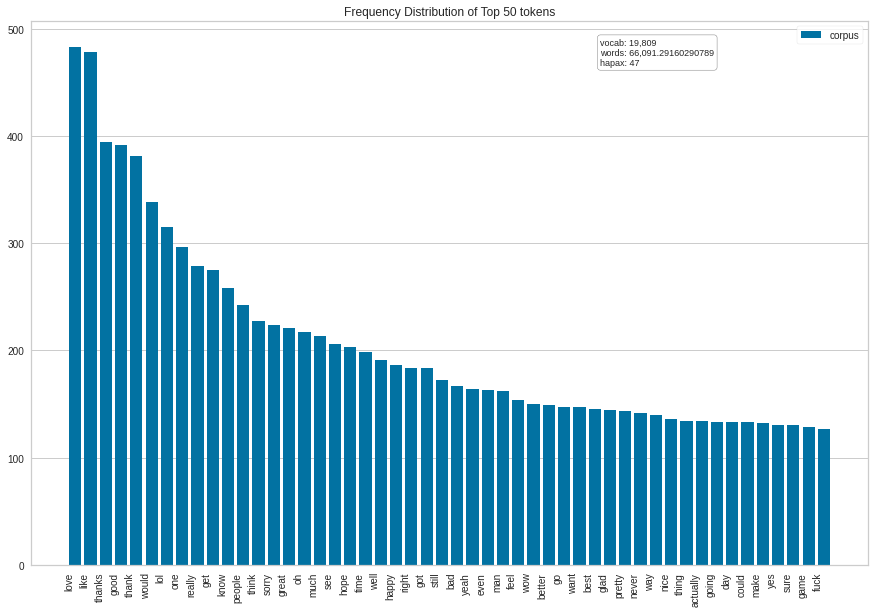

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [69]:
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v', size=(1080, 720))
visualizer.fit(X_train_vec)
visualizer.show()

In [70]:
Models_acc = {}
Models_micro = {}
Models_macro = {}

def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')

    hamLoss = hamming_loss(test_labels, predictions)
    
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    
    Models_acc[modelName] = accuracy
    Models_micro[modelName] = micro_f1
    Models_macro[modelName] = macro_f1

## **KNN**

In [71]:
knn = KNeighborsClassifier()

knn.fit(X_train_vec, y_train)
knnPredictions = knn.predict(X_test_vec)
metricsReport("knn", y_test, knnPredictions)

------knn Model Metrics-----
Accuracy: 0.2639
Hamming Loss: 0.2404
Precision:
  - Macro: 0.6089
  - Micro: 0.4084
Recall:
  - Macro: 0.2314
  - Micro: 0.2826
F1-measure:
  - Macro: 0.2587
  - Micro: 0.3340


## **Decision Tree**

In [72]:
dt = DecisionTreeClassifier()
dt.fit(X_train_vec, y_train)
dtPreds = dt.predict(X_test_vec)
metricsReport("Decision Tree", y_test, dtPreds)

------Decision Tree Model Metrics-----
Accuracy: 0.5938
Hamming Loss: 0.1530
Precision:
  - Macro: 0.5471
  - Micro: 0.6461
Recall:
  - Macro: 0.4985
  - Micro: 0.6261
F1-measure:
  - Macro: 0.5201
  - Micro: 0.6359


## **Bagging**

In [73]:
bag = OneVsRestClassifier(BaggingClassifier(n_jobs=-1))
bag.fit(X_train_vec, y_train)
bagPreds = bag.predict(X_test_vec)
metricsReport("Bagging", y_test, bagPreds)

------Bagging Model Metrics-----
Accuracy: 0.5253
Hamming Loss: 0.1297
Precision:
  - Macro: 0.6544
  - Micro: 0.7389
Recall:
  - Macro: 0.4924
  - Micro: 0.6067
F1-measure:
  - Macro: 0.5572
  - Micro: 0.6663


## **Random Forest**

In [74]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_vec, y_train)
rfPreds = rf.predict(X_test_vec)
metricsReport("Random Forest", y_test, rfPreds)

------Random Forest Model Metrics-----
Accuracy: 0.5852
Hamming Loss: 0.1211
Precision:
  - Macro: 0.7573
  - Micro: 0.7854
Recall:
  - Macro: 0.4342
  - Micro: 0.5947
F1-measure:
  - Macro: 0.5314
  - Micro: 0.6769


## **Boosting**

In [75]:
boostClassifier = OneVsRestClassifier(GradientBoostingClassifier())
boostClassifier.fit(X_train_vec, y_train)
boostPreds = boostClassifier.predict(X_test_vec)
metricsReport("Boosting", y_test, boostPreds)

------Boosting Model Metrics-----
Accuracy: 0.4389
Hamming Loss: 0.1303
Precision:
  - Macro: 0.7937
  - Micro: 0.8725
Recall:
  - Macro: 0.3451
  - Micro: 0.4557
F1-measure:
  - Macro: 0.4514
  - Micro: 0.5987


## **Multinomial Naive Bayes**

In [76]:
nb = OneVsRestClassifier(MultinomialNB())
nb.fit(X_train_vec, y_train)

nbPreds = nb.predict(X_test_vec)
metricsReport("Multinomial NB", y_test, nbPreds)

------Multinomial NB Model Metrics-----
Accuracy: 0.5074
Hamming Loss: 0.1498
Precision:
  - Macro: 0.6903
  - Micro: 0.7042
Recall:
  - Macro: 0.1972
  - Micro: 0.5134
F1-measure:
  - Macro: 0.1787
  - Micro: 0.5939


## **Linear SVC**

In [77]:
svm = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svm.fit(X_train_vec, y_train)

svmPreds = svm.predict(X_test_vec)
metricsReport("SVC Sq. Hinge Loss", y_test, svmPreds)

------SVC Sq. Hinge Loss Model Metrics-----
Accuracy: 0.5719
Hamming Loss: 0.1237
Precision:
  - Macro: 0.7103
  - Micro: 0.7570
Recall:
  - Macro: 0.4903
  - Micro: 0.6189
F1-measure:
  - Macro: 0.5722
  - Micro: 0.6810


## **Label Powerset**

In [78]:
powerSetSVC = LabelPowerset(LinearSVC())
powerSetSVC.fit(X_train_vec, y_train)

powerSetSVCPreds = powerSetSVC.predict(X_test_vec)
metricsReport("Power Set SVC", y_test, powerSetSVCPreds)

------Power Set SVC Model Metrics-----
Accuracy: 0.6474
Hamming Loss: 0.1319
Precision:
  - Macro: 0.6666
  - Micro: 0.7021
Recall:
  - Macro: 0.5281
  - Micro: 0.6628
F1-measure:
  - Macro: 0.5812
  - Micro: 0.6819


## **Comparison of ML-Based models**

In [79]:
print("  Model Name " + " "*10 + "| Macro-F1 Score")
print("-------------------------------------------")
for key, value in Models_macro.items():
    print("  " + key, " "*(20-len(key)) + "|", value)
    print("-------------------------------------------")

  Model Name           | Macro-F1 Score
-------------------------------------------
  knn                  | 0.2586583715884251
-------------------------------------------
  Decision Tree        | 0.5201428662537597
-------------------------------------------
  Bagging              | 0.5571535898738487
-------------------------------------------
  Random Forest        | 0.5314048736159019
-------------------------------------------
  Boosting             | 0.45144117489359326
-------------------------------------------
  Multinomial NB       | 0.178698097082095
-------------------------------------------
  SVC Sq. Hinge Loss   | 0.5722416520787128
-------------------------------------------
  Power Set SVC        | 0.5811792210270641
-------------------------------------------


# **LSTM with glove embedding and single output layer**

In [80]:
y_train =  df_train.drop(['Text', 'ID'], axis=1)
y_val = df_dev.drop(['Text', 'ID'], axis=1)
y_test = df_test.drop(['Text', 'ID'], axis=1)
y_train.head()

,anger,fear,joy,sadness,surprise
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,1,0,0


In [81]:
X_train = df_train['Text']
X_val = df_dev['Text']
X_test = df_test['Text']
X_train.head()

0                       why the fuck is bayless isoing
1                          to make her feel threatened
2                               dirty southern wankers
3    omg peyton is not good enough to help us in th...
4    yes i heard abt the f bombs that has to be why...
Name: Text, dtype: object

In [82]:
X_train.shape

(28427,)

In [83]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 256

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [84]:
print(X_train.shape)
X_train

(28427, 256)


array([[  82,    2,  152, ...,    0,    0,    0],
       [   4,  109,   72, ...,    0,    0,    0],
       [1577, 2845,    0, ...,    0,    0,    0],
       ...,
       [  30,   15,    5, ...,    0,    0,    0],
       [  65,   23,    6, ...,    0,    0,    0],
       [ 261,    2, 1686, ...,    0,    0,    0]], dtype=int32)

In [85]:
embeddings_dictionary = dict()

glove_file = open('../input/d/sarfrazahmad307/emotions/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [86]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(5, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [87]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 100)          1998000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 2,115,893
Trainable params: 117,893
Non-trainable params: 1,998,000
_________________________________________________________________
None


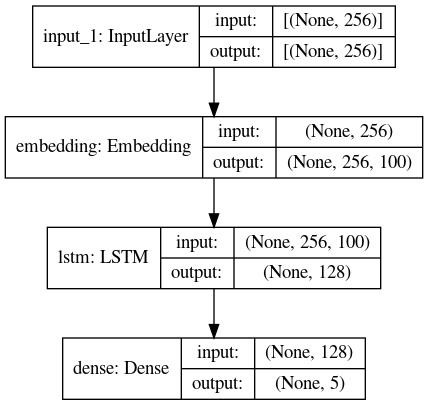

In [88]:
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [89]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_val, y_val))

Epoch 1/5
223/223 [==============================] - 10s 29ms/step - loss: 0.4646 - acc: 0.5638 - val_loss: 0.4124 - val_acc: 0.5805
Epoch 2/5
223/223 [==============================] - 5s 24ms/step - loss: 0.4149 - acc: 0.5737 - val_loss: 0.4117 - val_acc: 0.5805
Epoch 3/5
223/223 [==============================] - 5s 24ms/step - loss: 0.4139 - acc: 0.5746 - val_loss: 0.4118 - val_acc: 0.5805
Epoch 4/5
223/223 [==============================] - 5s 23ms/step - loss: 0.4148 - acc: 0.5745 - val_loss: 0.4120 - val_acc: 0.5805
Epoch 5/5
223/223 [==============================] - 5s 24ms/step - loss: 0.4140 - acc: 0.5756 - val_loss: 0.4114 - val_acc: 0.5805


In [90]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

110/110 [==============================] - 1s 7ms/step - loss: 0.4165 - acc: 0.5625
Test Score: 0.4165327548980713
Test Accuracy: 0.5625


In [91]:
y_pred = model.predict(X_test, batch_size=128, verbose=True)

28/28 [==============================] - 1s 11ms/step


In [92]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [93]:
y = np.array(y_test) >= 0.5
y_p = np.array(y_pred) >= 0.5

In [94]:
print(classification_report(y, y_p)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       660
           1       0.00      0.00      0.00        91
           2       0.57      1.00      0.73      2022
           3       0.00      0.00      0.00       358
           4       0.00      0.00      0.00       624

   micro avg       0.57      0.54      0.56      3755
   macro avg       0.11      0.20      0.15      3755
weighted avg       0.31      0.54      0.39      3755
 samples avg       0.57      0.55      0.56      3755



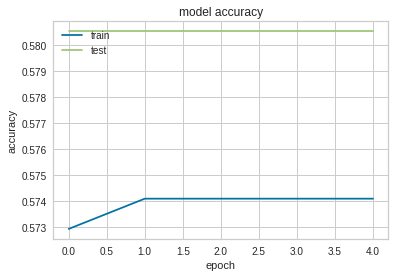

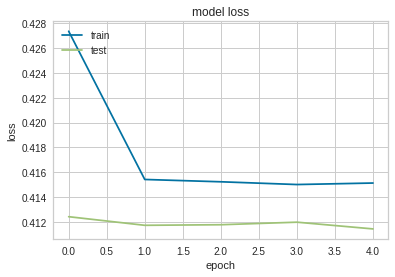

In [95]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# **Word2Vec**

In [96]:
y_train =  df_train.drop(['Text', 'ID'], axis=1)
y_val = df_dev.drop(['Text', 'ID'], axis=1)
y_test = df_test.drop(['Text', 'ID'], axis=1)
y_train.head()

,anger,fear,joy,sadness,surprise
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,1,0,0


In [97]:
X_train = df_train['Text']
X_val = df_dev['Text']
X_test = df_test['Text']
X_train.head()

0                       why the fuck is bayless isoing
1                          to make her feel threatened
2                               dirty southern wankers
3    omg peyton is not good enough to help us in th...
4    yes i heard abt the f bombs that has to be why...
Name: Text, dtype: object

In [98]:
X_train.apply(lambda x:len(str(x).split())).max()

40

In [99]:
max_features = 5000
maxlen = 256

In [100]:
token=tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
token.fit_on_texts(X_train)

In [101]:
X_train_seq=token.texts_to_sequences(X_train)
X_test_seq=token.texts_to_sequences(X_test)

In [102]:
#zero pad the sequences
from keras.preprocessing import sequence, text
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=maxlen)

word_index = token.word_index

len(token.word_index)##251102

19979

In [106]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz
!ls -l

--2022-05-01 20:03:20--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.195.112
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.195.112|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-05-01 20:03:22 ERROR 404: Not Found.

gzip: GoogleNews-vectors-negative300.bin.gz: No such file or directory
total 489972
---------- 1 root root       263 May  1 18:13 __notebook_source__.ipynb
-rw-r--r-- 1 root root 498688457 May  1 19:46 model.pth
-rw-r--r-- 1 root root     27771 May  1 19:58 model_plot4a.png
-rw-r--r-- 1 root root    295847 May  1 18:15 test.csv
-rw-r--r-- 1 root root   2402873 May  1 18:15 train.csv
-rw-r--r-- 1 root root    300560 May  1 18:15 val.csv


In [105]:
from gensim.models import Word2Vec, KeyedVectors
# Load pretrained Glove model (in word2vec form)
word2vec_model = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)

FileNotFoundError: [Errno 2] No such file or directory: './GoogleNews-vectors-negative300.bin'

In [ ]:
#Embedding length based on selected model - we are using 50d here.
embedding_vector_length = 300

In [ ]:
#Initialize embedding matrix
embedding_matrix = np.zeros((max_features + 1, embedding_vector_length))
print(embedding_matrix.shape)

In [ ]:
for word, i in sorted(token.word_index.items(),key=lambda x:x[1]):
    if i > (max_features+1):
        break
    try:
        embedding_vector = word2vec_model[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass
        
embedding_matrix

In [ ]:
#Initialize model
import tensorflow as tf
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [ ]:
from keras.layers.recurrent import LSTM, GRU,SimpleRNN

# A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(tf.keras.layers.Embedding(max_features + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=maxlen) #Number of words in each review
         )
model.add(SimpleRNN(100))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(X_train_pad,
                    y_train,
                    epochs=10,
                    batch_size=32,          
                    validation_data=(X_test_pad, y_test))

In [ ]:
y_pred = model.predict(X_test_pad, batch_size=1000, verbose=True)

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y = np.array(y_test) >= 0.5
y_p = np.array(y_pred) >= 0.5

In [ ]:
print(classification_report(y, y_p)) 

In [ ]:
accuracy_score(y,y_p)